In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
N = 50
x_all = [0.0]*N
y_all = [0.0]*N
box = 1

k=0
for i in range (0,int(N/5)):
    for j in range(0,int(N/10)):
        x_all[k] = i*0.1*box
        if math.fmod(i,2) == 0.0:
#            y_all[k] = j*0.2*box + (np.random.rand()-0.5)*0.1
            y_all[k] = j*0.2*box
        else:
#            y_all[k] = j*0.2*box + 0.1 + (np.random.rand()-0.5)*0.1
            y_all[k] = j*0.2*box + 0.1
        k=k+1

x_start = [0.0]*N
y_start = [0.0]*N
for i in range (0,N):
    x_start[i] = x_all[i]
    y_start[i] = y_all[i]


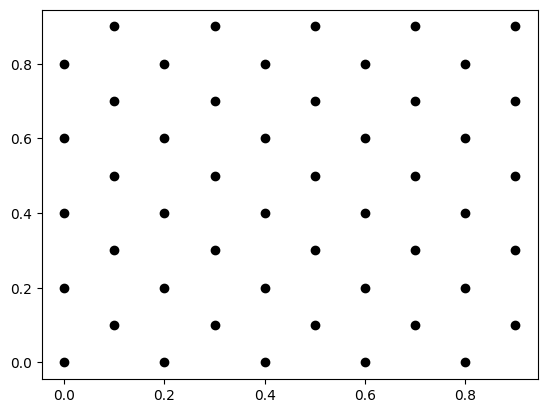

In [3]:
##  Visualize starting configuration  ##

for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
plt.show()


In [4]:
###  Use this for Simple Pairwise Potential  ##

def force(x_all,y_all):

    en = 0
    c = -1/4000
    rc = 0.2
    forces_x = [0.0]*N
    forces_y = [0.0]*N

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            if r <= rc:
                ff = c/(r*r*r)
                forces_x[i] = forces_x[i] + ff*xr
                forces_x[j] = forces_x[j] - ff*xr
                forces_y[i] = forces_y[i] + ff*yr
                forces_y[j] = forces_y[j] - ff*yr
                en = en + c/r

    return(en,forces_x,forces_y)


In [ ]:
###  Use this for Lennard Jones Potential  ##
###  (https://en.wikipedia.org/wiki/Lennard-Jones_potential)

def force(x_all,y_all):

    en = 0
    forces_x = [0.0]*N
    forces_y = [0.0]*N
    rc = 0.2
    eps = 1e-42

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)

            r2 = xr*xr + yr*yr

            if r2 <= rc*rc:
                r2i = 1/r2
                r6i = np.power(r2i,3)
                ff = 48*eps*r2i*r6i*(r6i-0.5)
                forces_x[i] = forces_x[i] + ff*xr
                forces_x[j] = forces_x[j] - ff*xr
                forces_y[i] = forces_y[i] + ff*yr
                forces_y[j] = forces_y[j] - ff*yr
                en = (en + 4*eps*r6i*(r6i-1))

    return(en,forces_x,forces_y)


In [5]:
###  Use this for Calculating Average Pairwise Distances  ##

def pair_distance(x_all,y_all):

    k = 0
    dist_avg = 0

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            dist_avg = dist_avg + r
            k = k+1

    dist_avg = dist_avg/k

    return(dist_avg)


In [29]:
##  Define MD Parameters  ##

#Temp_start = 30
dt = 1e-4
tmax = 1e-2
m = 1/2000


In [30]:
def init():

    x = [0.0]*N
    y = [0.0]*N
    xm = [0.0]*N
    ym = [0.0]*N

    vx = [0.0]*N
    vy = [0.0]*N
#    sumvx = 0
#    sumvy = 0
    sumv2 = 0

    k = 0
    for i in range (0,int(N/5)):
        for j in range(0,int(N/10)):
#            x[k] = i*0.1*box
            x[k] = i*0.1*box + (np.random.rand()-0.5)*5e-5
            if math.fmod(i,2) == 0.0:
#                y[k] = j*0.2*box
                y[k] = j*0.2*box + (np.random.rand()-0.5)*5e-5
            else:
#                y[k] = j*0.2*box + 0.1
                y[k] = j*0.2*box + 0.1 + (np.random.rand()-0.5)*5e-5
            k=k+1

    k = 0
    for i in range (0,int(N/5)):
        for j in range(0,int(N/10)):
            xm[k] = i*0.1*box + (np.random.rand()-0.5)*5e-5
            if math.fmod(i,2) == 0.0:
                ym[k] = j*0.2*box + (np.random.rand()-0.5)*5e-5
            else:
                ym[k] = j*0.2*box + 0.1 + (np.random.rand()-0.5)*5e-5
            k=k+1

    for i in range(0,N):
        vx[i] = (x[i]-xm[i])/dt
        vy[i] = (y[i]-ym[i])/dt
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]


#     for i in range(0,N):
#         vx[i] = (np.random.rand()-0.5)*1e-1
#         vy[i] = (np.random.rand()-0.5)*1e-1
#         sumvx = sumvx + vx[i]
#         sumvy = sumvy + vy[i]
#         sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]

#     sumvx = sumvx/N
#     sumvy = sumvy/N
#     sumv2 = sumv2/N

#     fs = np.sqrt(3*Temp_start/sumv2)

#     for i in range(0,N):
#         vx[i] = (vx[i] - sumvx)*fs
#         vy[i] = (vy[i] - sumvy)*fs
#         xm[i] = x[i] - vx[i]*dt
#         ym[i] = y[i] - vy[i]*dt

    PE_start, fx, fy = force(x,y)
    KE_start = 0.5*sumv2*m*N

    return(x, y, vx, vy, xm, ym, PE_start, KE_start)


In [31]:
def integrate(en, forces_x, forces_y, x, xm, y, ym):

    sumvx = 0
    sumvy = 0
    sumv2 = 0
    vx = [0.0]*N
    vy = [0.0]*N

    for i in range(0,N):
        xx = 2*x[i] - xm[i] + dt*dt*forces_x[i]
        yy = 2*y[i] - ym[i] + dt*dt*forces_y[i]
        vx[i] = (xx-xm[i])/(2*dt)
        vy[i] = (yy-ym[i])/(2*dt)
        sumvx = sumvx + vx[i]
        sumvy = sumvy + vy[i]
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]
        xm[i] = x[i]
        x[i] = xx
        ym[i] = y[i]
        y[i] = yy

    Temp = sumv2/(3*N)
    pot = en
    kin = 0.5*sumv2*m*N
    etot = pot + kin

#    etot = (en + 0.5*sumv2)/N

    return(Temp, pot, kin, etot, x, y)



In [32]:
def sample(x,y):

    return(pair_distance(x,y))


In [40]:
def md(tmax,dt,nsamp):

    x, y, vx, vy, xm, ym, pe_start, ke_start = init()
    t = 0
    steps = int(tmax/dt)
    s = int(steps/nsamp)
    times = [0.0]*s
    PE = [0.0]*s
    KE = [0.0]*s
    TE = [0.0]*s
    Temp = [0.0]*s
    pair_dist = [0.0]*s

    x_new = x
    y_new = y
    k = 0

    for i in range(0,steps):
        en, fx, fy = force(x_new,y_new)
        T, pe, ke, te, x_new, y_new = integrate(en, fx, fy, x, xm, y, ym)
        t = t+dt
        if math.fmod(i, nsamp) == 0.0:
            k = int(i/nsamp)
            PE[k] = pe
            KE[k] = ke
            TE[k] = te
            Temp[k] = T
            times[k] = t
            pair_dist[k] = sample(x_new,y_new)

    plt.plot(times[:], PE[:], c = 'r')
    plt.plot(times[:], KE[:], c = 'b')
    plt.plot(times[:], TE[:], c = 'grey')
#    plt.plot(times[:], Temp[:], c='k')
#    plt.plot(times[:], pair_dist[:], c = 'g')

    return(PE, KE, TE, x_new, y_new, pair_dist)



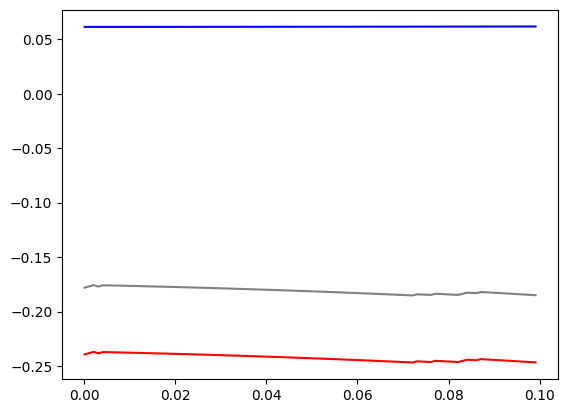

In [41]:

dt = 1e-4
tmax = 0.1
nsamp = 10

PE, KE, TE, x_final, y_final, pair_dist = md(tmax,dt,nsamp)


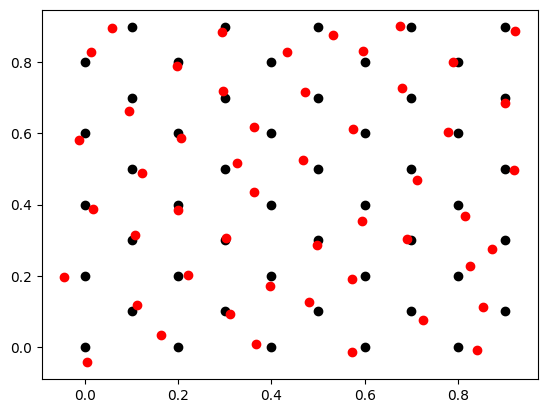

In [42]:
for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
    plt.scatter(x_final[i],y_final[i],c='r')
plt.show()
